In [26]:
#!pip install -q transformers datasets torch
!pip install -q datasets

In [27]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer
from datasets import load_dataset
import wandb

import warnings
warnings.filterwarnings('ignore')

In [28]:
torch.cuda.is_available()

True

In [29]:
# Desabilita o WandB (ou configure conforme sua preferência)
wandb.init(mode="disabled")

# Carregar dataset

In [ ]:
# Lista de modelos a serem fine-tuned
'''
model_names = [
    "meta-llama/Llama-3.1-8B-Instruct",
    "Qwen/Qwen2.5-Math-1.5B"
]
'''

'\nmodel_names = [\n    "meta-llama/Llama-3.1-8B-Instruct",\n    "Qwen/Qwen2.5-Math-1.5B"\n]\n'

In [30]:
# Lista de modelos a serem fine-tuned

model_names = [
    "gpt2",
    "distilgpt2",
    "EleutherAI/gpt-neo-125M",
    "facebook/opt-125m"
]


In [67]:
VERSION_DATASET = '5k'
N_LANCES = 3

NUM_EPOCHS=100

In [66]:
# Carrega o dataset
dataset = load_dataset(f"muriloms/football-events-statsbomb360-la-liga-{N_LANCES}-{VERSION_DATASET}")

README.md:   0%|          | 0.00/529 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/451k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/59.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/60.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

# Funções auxiliares

In [68]:
def extract_epoch_metrics(trainer):
    """
    A partir do trainer.state.log_history, extrai os logs que contêm o valor de loss e a
    informação de epoch. Em seguida, agrupa os logs por época (utilizando a função ceil para
    transformar frações de época no respectivo número inteiro) e calcula a média da loss em cada época.

    Retorna um DataFrame com as colunas:
      - epoch: a época (inteiro)
      - training_loss: média da loss registrada naquela época
    """
    logs = trainer.state.log_history  # lista de dicionários
    # Converte a lista em um DataFrame
    df_logs = pd.DataFrame(logs)
    # Filtra as entradas que possuem loss registrada
    df_logs = df_logs[df_logs["loss"].notnull()].copy()
    # Cria uma coluna "epoch_group": arredonda a época para o inteiro superior
    df_logs["epoch_group"] = df_logs["epoch"].apply(lambda x: math.ceil(x))
    # Agrupa por epoch e calcula a média da loss para cada grupo
    epoch_metrics = df_logs.groupby("epoch_group")["loss"].mean().reset_index()
    # Renomeia as colunas para maior clareza
    epoch_metrics = epoch_metrics.rename(columns={"epoch_group": "epoch", "loss": "training_loss"})
    return epoch_metrics

In [69]:
# Define o comprimento máximo das sequências tokenizadas
max_seq_length = 200

In [70]:
def preprocess_function(examples, tokenizer):
    """
    Concatena os campos 'history' e 'action_label' para formar um único texto de entrada,
    tokeniza o texto aplicando truncamento e padding para um comprimento fixo, e replica os input_ids
    em labels para a tarefa de modelagem de linguagem causal.
    """
    texts = [f"{history}\nNextAction: {label}"
             for history, label in zip(examples["history"], examples["action_label"])]

    model_inputs = tokenizer(
        texts,
        max_length=max_seq_length,
        truncation=True,
        padding="max_length",  # Para padronizar o comprimento das sequências
        return_attention_mask=True
    )

    model_inputs["labels"] = model_inputs["input_ids"].copy()
    return model_inputs

In [71]:
# Função para realizar o fine-tuning para um modelo específico
def fine_tune_model(model_name):
    print(f"\nFine-tuning model: {model_name}\n{'=' * 60}")

    # Carrega o tokenizer e, se necessário, define o token de padding
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    print("Salvar Tokenizer no Hugging Face")
    tokenizer.push_to_hub(f"tcc-football-events-tokenizer-{model_name.replace('/', '_')}-{N_LANCES}-{VERSION_DATASET}")

    # Carrega o modelo para LM causal
    model = AutoModelForCausalLM.from_pretrained(model_name)

    # Tokeniza o dataset utilizando a função de pré-processamento, que é aplicada em modo batched
    tokenized_dataset = dataset.map(
        lambda examples: preprocess_function(examples, tokenizer),
        batched=True,
        remove_columns=["history", "action_label"],
        load_from_cache_file=True
    )

    # Cria o data collator adequado para a LM causal
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    )

    # Define os parâmetros de treinamento
    output_dir = f"tcc-football-events-finetune-{model_name.replace('/', '_')}-{N_LANCES}-{VERSION_DATASET}-{NUM_EPOCHS}"
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        logging_steps=50,
        learning_rate=5e-5,
        weight_decay=0.01,
        fp16=True,  # Utilize FP16 se sua GPU oferecer suporte a precisão mista
        push_to_hub=False,
        save_total_limit=2
    )

    # Cria o Trainer e inicia o treinamento
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        data_collator=data_collator
    )

    trainer.train()
    #trainer.save_model(os.path.join(output_dir, "final_model"))
    print("Salvar Modelo no Hugging Face")
    trainer.push_to_hub(f"tcc-football-events-finetune-{model_name.replace('/', '_')}-{N_LANCES}-{VERSION_DATASET}-{NUM_EPOCHS}")

    # Retorna o trainer e o modelo treinado, caso você deseje fazer avaliações adicionais
    return trainer, model, tokenized_dataset

# Fine-tuning

In [36]:
from huggingface_hub import notebook_login
notebook_login()

In [72]:
# Realiza o fine-tuning para cada modelo da lista
results = {}
model_epoch_results = {}
for m_name in model_names:
    trainer, model,tokenized_dataset = fine_tune_model(m_name)
    results[m_name] = trainer.evaluate(tokenized_dataset["test"])
    print(f"Evaluation results for {m_name}: {results[m_name]}\n{'-' * 60}")

    epoch_df = extract_epoch_metrics(trainer)
    model_epoch_results[m_name] = epoch_df


Fine-tuning model: gpt2
Salvar Tokenizer no Hugging Face


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.371400,0.360859
2,0.325900,0.332297
3,0.317900,0.319660
4,0.311100,0.317012
5,0.298800,0.315548
6,0.301600,0.313106
7,0.296800,0.313190
8,0.278700,0.311760
9,0.268700,0.312460
10,0.260300,0.316606


Salvar Modelo no Hugging Face


Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

events.out.tfevents.1738786470.a5c821367404.1895.24:   0%|          | 0.00/892k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Evaluation results for gpt2: {'eval_loss': 0.7791846990585327, 'eval_runtime': 3.5332, 'eval_samples_per_second': 141.516, 'eval_steps_per_second': 70.758, 'epoch': 100.0}
------------------------------------------------------------

Fine-tuning model: distilgpt2
Salvar Tokenizer no Hugging Face


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss
1,0.394700,0.381743
2,0.343300,0.345333
3,0.330800,0.327668
4,0.324600,0.325947
5,0.312200,0.322051
6,0.315400,0.318174
7,0.310100,0.318076
8,0.293800,0.315154
9,0.286300,0.314205
10,0.284300,0.314195


Salvar Modelo no Hugging Face


model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

events.out.tfevents.1738796368.a5c821367404.1895.26:   0%|          | 0.00/892k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Evaluation results for distilgpt2: {'eval_loss': 0.6907168030738831, 'eval_runtime': 2.2431, 'eval_samples_per_second': 222.904, 'eval_steps_per_second': 111.452, 'epoch': 100.0}
------------------------------------------------------------

Fine-tuning model: EleutherAI/gpt-neo-125M
Salvar Tokenizer no Hugging Face


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss
1,0.348000,0.348286
2,0.313700,0.329825
3,0.305500,0.323560
4,0.298900,0.320941
5,0.285000,0.321421
6,0.281600,0.323613
7,0.260900,0.337140
8,0.231800,0.352772
9,0.212100,0.367326
10,0.192200,0.387239


KeyboardInterrupt: 

In [73]:
results

{'gpt2': {'eval_loss': 0.7791846990585327,
  'eval_runtime': 3.5332,
  'eval_samples_per_second': 141.516,
  'eval_steps_per_second': 70.758,
  'epoch': 100.0},
 'distilgpt2': {'eval_loss': 0.6907168030738831,
  'eval_runtime': 2.2431,
  'eval_samples_per_second': 222.904,
  'eval_steps_per_second': 111.452,
  'epoch': 100.0}}

In [74]:
# Calcular a perplexity e organizar os dados em uma lista de dicionários
data = []
for model_name, metrics in results.items():
    loss = metrics.get("eval_loss", None)
    # A perplexity é definida como a exponenciação da loss, assumindo que a loss é calculada como log-loss
    perplexity = math.exp(loss) if loss is not None else None
    data.append({
        "model_name": model_name,
        "eval_loss": loss,
        "perplexity": perplexity
    })

In [75]:
# Criar um DataFrame com os resultados
results_df = pd.DataFrame(data)
print("Evaluation Results Summary:")
results_df

Evaluation Results Summary:


,model_name,eval_loss,perplexity
0,gpt2,0.779185,2.179694
1,distilgpt2,0.690717,1.995145


In [76]:
results_df.to_csv(f"models_evaluation_{N_LANCES}_{VERSION_DATASET}_{NUM_EPOCHS}.csv")

([0, 1], [Text(0, 0, 'gpt2'), Text(1, 0, 'distilgpt2')])

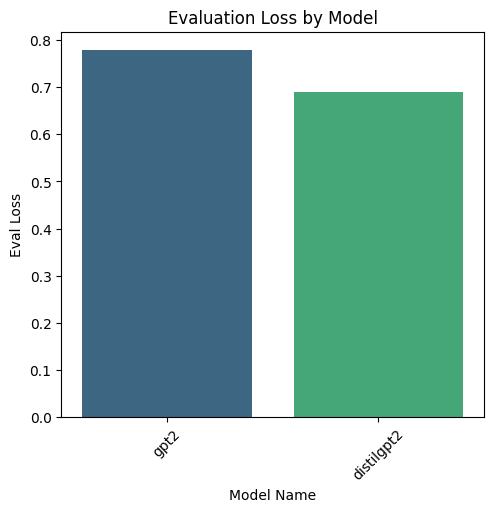

In [77]:
# Gerar gráficos comparativos para Loss e Perplexity
plt.figure(figsize=(12, 5))

# Gráfico de barras para Evaluation Loss
plt.subplot(1, 2, 1)
sns.barplot(x="model_name", y="eval_loss", data=results_df, palette="viridis")
plt.title("Evaluation Loss by Model")
plt.xlabel("Model Name")
plt.ylabel("Eval Loss")
plt.xticks(rotation=45)

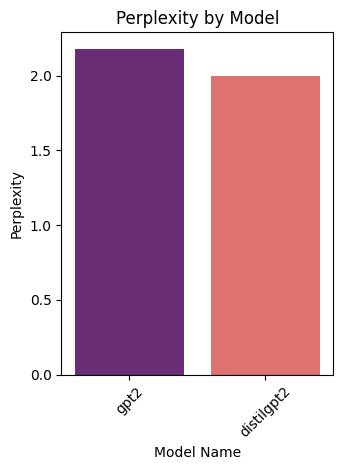

In [78]:
# Gráfico de barras para Perplexity
plt.subplot(1, 2, 2)
sns.barplot(x="model_name", y="perplexity", data=results_df, palette="magma")
plt.title("Perplexity by Model")
plt.xlabel("Model Name")
plt.ylabel("Perplexity")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [79]:
# Converte os resultados em uma lista de DataFrames e adiciona uma coluna 'model'
all_results_training_loss = []
for model_name, df_epoch in model_epoch_results.items():
    df_epoch["model"] = model_name
    all_results_training_loss.append(df_epoch)

In [80]:
# Concatena todos os DataFrames em um único DataFrame
all_results_training_loss_df = pd.concat(all_results_training_loss, ignore_index=True)
print("Combined Epoch Metrics:")
all_results_training_loss_df

Combined Epoch Metrics:


,epoch,training_loss,model
0,1,0.488312,gpt2
1,2,0.352780,gpt2
2,3,0.326325,gpt2
3,4,0.314063,gpt2
4,5,0.305270,gpt2
...,...,...,...
195,96,0.056970,distilgpt2
196,97,0.056742,distilgpt2
197,98,0.056580,distilgpt2
198,99,0.056407,distilgpt2


In [81]:
all_results_training_loss_df.to_csv(f"models_training_loss_{N_LANCES}_{VERSION_DATASET}_{NUM_EPOCHS}.csv")

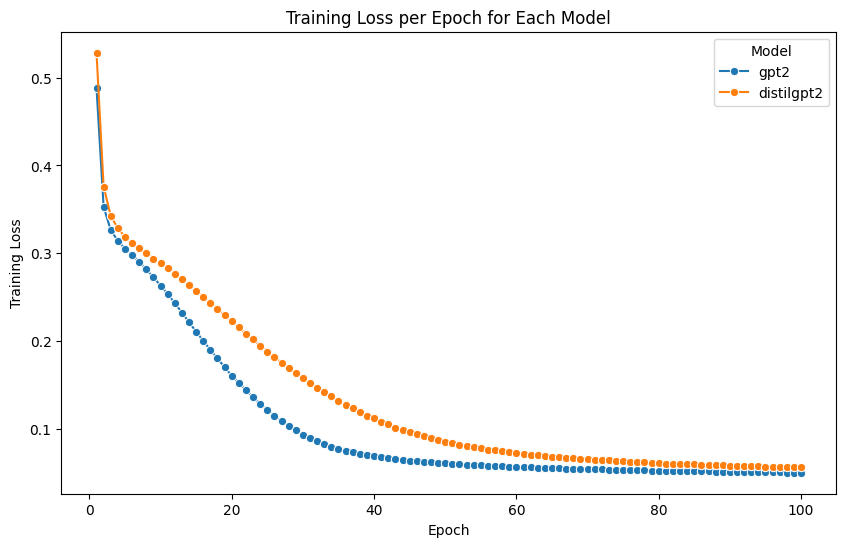

In [82]:
# Geração dos gráficos comparativos
plt.figure(figsize=(10, 6))
sns.lineplot(data=all_results_training_loss_df, x="epoch", y="training_loss", hue="model", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch for Each Model")
plt.legend(title="Model", loc="upper right")
plt.show()

In [ ]:
# Extract the generated text
generated_text = result[0]["generated_text"]

print("=== MODEL OUTPUT ===")
print(generated_text)
print("====================")

=== MODEL OUTPUT ===
You are a model specialized in predicting the next action in a soccer match.
You will be given a detailed description of a current match situation (the "context").
Your task is to provide only the next action or play, without repeating the context,
without explaining any reasoning, and without adding extra details.

Context:
At minute 12:30, Forward John Doe from Team X at coordinates (70, 30) performed a Dribble.

Question:
What is the next play in one concise sentence?

Answer:

Forward John Doe from Team Y at coordinates (68, 30) performed a Dribble.

Question:

What type of strike was the last strike used by Team Y? For example, was the strike the
